In [23]:

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

In [27]:
import torch
import pandas as pd
from src.tools.preprocess import preprocess_data
import matplotlib.pyplot as plt
import rasterio
from skimage import exposure
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import joblib

from sklearn.metrics import classification_report

import os
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch
from PIL import Image

In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [26]:
data = pd.read_csv('../data/processed/data.csv')
data_clean, anomalie = preprocess_data(data[data["dataset"] == "train"])
data_clean.head()

,Unnamed: 0,FarmID,category,Crop,State,District,Sub-District,SDate,HDate,CropCoveredArea,...,ndwi,gndvi,savi,msavi,SDate_year,SDate_month,SDate_day,HDate_year,HDate_month,HDate_day
0,0.0,1326576.0,Healthy,Paddy,Telangana,Medak,Kulcharam,2023-11-25,2024-04-14,97.0,...,8.488031,0.127153,0.151125,4232.596191,2023,11,25,2024,4,14
1,1.0,1326577.0,Healthy,Paddy,Telangana,Medak,Kulcharam,2023-11-13,2024-04-26,82.0,...,11.493762,0.187815,0.282110,3249.392822,2023,11,13,2024,4,26
2,2.0,1326578.0,Healthy,Paddy,Telangana,Medak,Kulcharam,2023-12-19,2024-04-28,92.0,...,10.166884,0.206553,0.309869,3741.956055,2023,12,19,2024,4,28
3,3.0,1331836.0,Diseased,Paddy,Telangana,Medak,Kulcharam,2023-02-11,2024-11-04,91.0,...,10.446196,0.220995,0.309350,3673.396729,2023,2,11,2024,11,4
4,4.0,1326579.0,Diseased,Paddy,Telangana,Medak,Kulcharam,2023-12-12,2024-05-19,94.0,...,8.665929,0.160657,0.269563,4227.338379,2023,12,12,2024,5,19


In [28]:
def scale_band(band):
    """Scale band data to 0-255."""
    band_min = np.min(band)
    band_max = np.max(band)
    return ((band - band_min) / (band_max - band_min) * 255).astype(np.uint8)


class TiffDataset(Dataset):
    def __init__(self, directory, data, type="train", transform=None, gamma=0.6, contrast_stretch=True):
        self.directory = directory
        self.transform = transform
        self.gamma = gamma
        self.contrast_stretch = contrast_stretch
        self.images = data.loc[(data["tif_path"].str.endswith('.tif')) & (data["dataset"] == type),
                               "tif_path"
                               ].tolist()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.directory, self.images[idx])

        # Open the image file
        with rasterio.open(img_path) as src:
            # Read RGB bands (assuming Sentinel-2 band order: Red=B4, Green=B3, Blue=B2)
            red = src.read(3)
            green = src.read(2)
            blue = src.read(1)
            # Stack the scaled RGB bands into a single image
            rgb = np.dstack((red, green,
                            blue)).astype(np.uint8)

            # Convert NumPy array to PIL Image
            rgb = Image.fromarray(rgb)

            if self.transform:
                rgb = self.transform(rgb)

        return rgb

In [29]:
transform = transforms.Compose([
    transforms.Resize((16, 16)),
    transforms.RandomRotation(degrees=30),
    transforms.RandomAffine(translate=(0.1, 0.1), degrees=20),
    transforms.ToTensor()
])

In [30]:

train_dataset = TiffDataset(
    directory="../data", data=data_clean, type="train", transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TiffDataset(
    directory="../data", data=data_clean, type="test", transform=transform)
test_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [31]:
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(3, 64, 3, stride=2, padding=1),  # 32x32 -> 16x16
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64),
            torch.nn.Dropout(0.2),

            torch.nn.Conv2d(64, 128, 3, stride=2, padding=1),  # 16x16 -> 8x8
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(128),
            torch.nn.Dropout(0.2),

            torch.nn.Conv2d(128, 256, 3, stride=2, padding=1),  # 8x8 -> 4x4
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(256),
            torch.nn.Flatten(),

            torch.nn.Linear(256 * 2 * 2, 64),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),

            torch.nn.Linear(64, 5)  # Code latent réduit à 4
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(5, 64),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),

            torch.nn.Linear(64, 256 * 2 * 2),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(256 * 2 * 2),

            torch.nn.Unflatten(1, (256, 2, 2)),
            torch.nn.ConvTranspose2d(
                256, 128, 3, stride=2, padding=1, output_padding=1),  # 4x4 -> 8x8
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(128),

            torch.nn.ConvTranspose2d(
                128, 64, 3, stride=2, padding=1, output_padding=1),   # 8x8 -> 16x16
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64),

            torch.nn.ConvTranspose2d(
                64, 3, 3, stride=2, padding=1, output_padding=1),    # 16x16 -> 32x32
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [111]:
import torch
import torch.nn as nn


class ImprovedAutoencoder(nn.Module):
    def __init__(self):
        super(ImprovedAutoencoder, self).__init__()

        # Paramètres de base
        self.latent_dim = 20  # Dimension latente réduite à 20
        self.initial_filters = 48  # Légèrement réduit pour compenser

        # Encoder avec architecture résiduelle
        self.encoder = nn.Sequential(
            # Première couche de convolution
            nn.Conv2d(3, self.initial_filters, 3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(self.initial_filters),

            # Bloc 1
            ResidualBlock(self.initial_filters, self.initial_filters * 2),
            nn.Conv2d(self.initial_filters * 2,
                      self.initial_filters * 2, 3, stride=2, padding=1),

            # Bloc 2
            ResidualBlock(self.initial_filters * 2, self.initial_filters * 4),
            nn.Conv2d(self.initial_filters * 4,
                      self.initial_filters * 4, 3, stride=2, padding=1),

            # Bloc 3
            ResidualBlock(self.initial_filters * 4, self.initial_filters * 6),
            nn.Conv2d(self.initial_filters * 6,
                      self.initial_filters * 6, 3, stride=2, padding=1),

            nn.Flatten(),
            # Réduction progressive vers la dimension latente
            nn.Linear(self.initial_filters * 6 * 2 * 2, 256),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(256),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(128),
            nn.Linear(128, self.latent_dim),
            nn.BatchNorm1d(self.latent_dim)
        )

        # Decoder avec attention
        self.decoder = nn.Sequential(
            # Expansion progressive depuis la dimension latente
            nn.Linear(self.latent_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, self.initial_filters * 6 * 2 * 2),
            nn.BatchNorm1d(self.initial_filters * 6 * 2 * 2),
            nn.LeakyReLU(0.2),

            nn.Unflatten(1, (self.initial_filters * 6, 2, 2)),

            # Bloc 1
            UpResidualBlock(self.initial_filters * 6,
                            self.initial_filters * 4),
            SelfAttention(self.initial_filters * 4),

            # Bloc 2
            UpResidualBlock(self.initial_filters * 4,
                            self.initial_filters * 2),
            SelfAttention(self.initial_filters * 2),

            # Bloc 3
            UpResidualBlock(self.initial_filters * 2, self.initial_filters),
            SelfAttention(self.initial_filters),

            # Couche finale
            nn.Conv2d(self.initial_filters, 3, 3, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()

        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels)
        )

        self.skip = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1)
        ) if in_channels != out_channels else nn.Identity()

        self.relu = nn.LeakyReLU(0.2)

    def forward(self, x):
        return self.relu(self.conv_block(x) + self.skip(x))


class UpResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpResidualBlock, self).__init__()

        self.conv_block = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels,
                               4, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels)
        )

        self.skip = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels,
                               4, stride=2, padding=1),
            nn.BatchNorm2d(out_channels)
        )

        self.relu = nn.LeakyReLU(0.2)

    def forward(self, x):
        return self.relu(self.conv_block(x) + self.skip(x))


class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.query = nn.Conv2d(in_channels, in_channels//8, 1)
        self.key = nn.Conv2d(in_channels, in_channels//8, 1)
        self.value = nn.Conv2d(in_channels, in_channels, 1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, C, width, height = x.size()

        proj_query = self.query(x).view(
            batch_size, -1, width*height).permute(0, 2, 1)
        proj_key = self.key(x).view(batch_size, -1, width*height)
        energy = torch.bmm(proj_query, proj_key)
        attention = torch.softmax(energy, dim=-1)

        proj_value = self.value(x).view(batch_size, -1, width*height)
        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, width, height)

        return self.gamma * out + x

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
num_epochs = 50
learning_rate = 0.0002

# Préparation des données
transform = transforms.Compose([
    transforms.Resize((16, 16)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# On utilise CIFAR-10 comme exemple
dataset = datasets.CIFAR10(root='./data', train=True,
                           download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialisation du modèle, de la fonction de perte et de l'optimiseur
model = ImprovedAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# Fonction pour visualiser les résultats


def visualize_reconstruction(model, dataloader, device, num_images=5):
    model.eval()
    with torch.no_grad():
        # Obtenir un batch de données
        images, _ = next(iter(dataloader))
        images = images[:num_images].to(device)

        # Reconstruire les images
        reconstructed = model(images)

        # Convertir les tensors en images
        images = images.cpu().numpy()
        reconstructed = reconstructed.cpu().numpy()

        # Afficher les résultats
        plt.figure(figsize=(10, 4))
        for i in range(num_images):
            # Image originale
            plt.subplot(2, num_images, i + 1)
            plt.imshow(np.transpose(images[i] * 0.5 + 0.5, (1, 2, 0)))
            plt.axis('off')
            if i == 0:
                plt.title('Original')

            # Image reconstruite
            plt.subplot(2, num_images, i + 1 + num_images)
            plt.imshow(np.transpose(reconstructed[i] * 0.5 + 0.5, (1, 2, 0)))
            plt.axis('off')
            if i == 0:
                plt.title('Reconstruit')

        plt.tight_layout()
        plt.show()

# Fonction d'entraînement


def train(model, dataloader, criterion, optimizer, num_epochs, device):
    model.train()
    losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch_idx, (images, _) in enumerate(dataloader):
            images = images.to(device)

            # Forward pass
            reconstructed = model(images)
            loss = criterion(reconstructed, images)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            # Afficher la progression
            if batch_idx % 100 == 0:
                print(f'Epoch [{
                      epoch+1}/{num_epochs}] Batch [{batch_idx}/{len(dataloader)}] Loss: {loss.item():.4f}')

        avg_loss = epoch_loss / len(dataloader)
        losses.append(avg_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}] Average Loss: {avg_loss:.4f}')

        # Visualiser les résultats tous les 5 epochs
        if (epoch + 1) % 5 == 0:
            visualize_reconstruction(model, dataloader, device)

    return losses


# Entraînement du modèle
losses = train(model, dataloader, criterion, optimizer, num_epochs, device)

# Visualiser la courbe de perte
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title('Evolution de la perte pendant l\'entraînement')
plt.xlabel('Epoch')
plt.ylabel('Perte moyenne')
plt.show()

# Sauvegarder le modèle
torch.save(model.state_dict(), 'autoencoder.pth')

# Pour charger le modèle plus tard


def load_model():
    model = ImprovedAutoencoder()
    model.load_state_dict(torch.load('autoencoder.pth'))
    model.eval()
    return model

# Exemple d'utilisation du modèle entraîné pour obtenir la représentation latente


def get_latent_representation(model, image):
    model.eval()
    with torch.no_grad():
        # S'assurer que l'image est un tensor sur le bon device
        if not isinstance(image, torch.Tensor):
            image = transform(image)
        if image.dim() == 3:
            image = image.unsqueeze(0)
        image = image.to(device)

        # Obtenir la représentation latente
        latent = model.encoder(image)
        return latent.cpu().numpy()

In [32]:
autoencoder = Autoencoder().to(device)

In [33]:
def train_dataset(autoencoder, train_loader, num_epochs=10, learning_rate=0.003):
    autoencoder = Autoencoder().to(device)
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)
    train_loss = []
    test_loss = []

    for epoch in range(num_epochs):
        total_loss = 0
        for batch_idx, data in enumerate(train_loader):
            autoencoder.train()
            # Normaliser les données entre 0 et 1
            data = data.to(device)
            optimizer.zero_grad()
            output = autoencoder(data)
            output = output.float()
            loss = criterion(output, data)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        else:
            autoencoder.eval()
            total_loss_test = 0
            for batch_idx, data in enumerate(test_dataloader):
                with torch.no_grad():
                    data = data.to(device)
                    output = autoencoder(data)
                    output = output.float()
                    loss = criterion(output, data)
                    total_loss_test += loss.item()
        avg_loss_test = total_loss_test / len(test_dataloader)
        avg_loss = total_loss / len(train_loader)
        train_loss.append(avg_loss)
        test_loss.append(avg_loss_test)
        print(f'Epoch {epoch}: Average Loss = {avg_loss:.4f}',
              f'Average Loss Test = {avg_loss_test:.4f}')

    return autoencoder, train_loss, test_loss

In [34]:
autoencoder, train_loss, test_loss = train_dataset(
    autoencoder, train_dataloader)

Epoch 0: Average Loss = 0.6226 Average Loss Test = 0.6007
Epoch 1: Average Loss = 0.6044 Average Loss Test = 0.5933
Epoch 2: Average Loss = 0.5996 Average Loss Test = 0.5899
Epoch 3: Average Loss = 0.5976 Average Loss Test = 0.5889
Epoch 4: Average Loss = 0.5971 Average Loss Test = 0.5866
Epoch 5: Average Loss = 0.5961 Average Loss Test = 0.5874
Epoch 6: Average Loss = 0.5948 Average Loss Test = 0.5862
Epoch 7: Average Loss = 0.5948 Average Loss Test = 0.5857
Epoch 8: Average Loss = 0.5934 Average Loss Test = 0.5861
Epoch 9: Average Loss = 0.5935 Average Loss Test = 0.5850


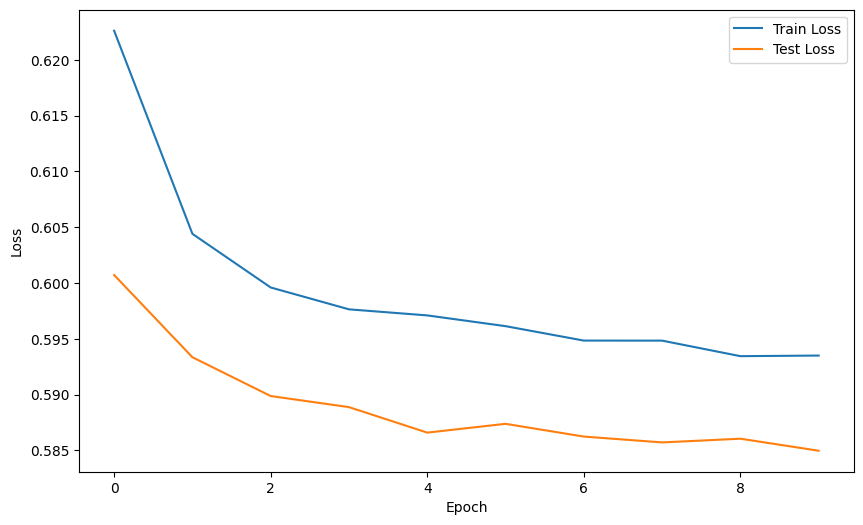

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label="Train Loss")
plt.plot(test_loss, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

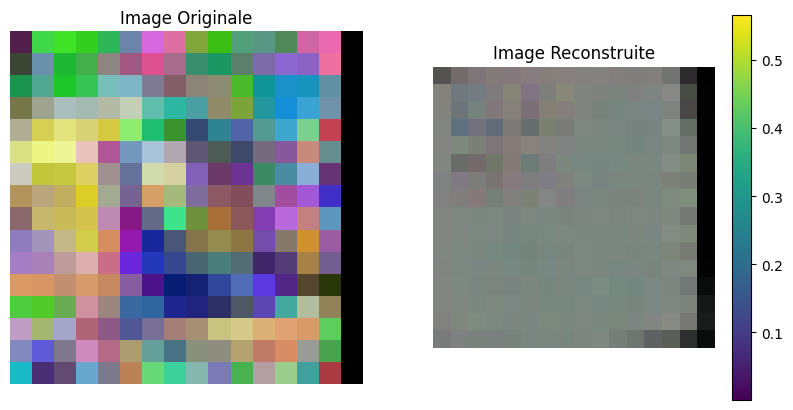

In [36]:
for batch_idx, data in enumerate(test_dataloader):
    with torch.no_grad():
        # Déplacer les données vers le bon appareil et sélectionner la première image du lot
        data = data.to(device)[0]
        # Créer une figure avec 2 sous-figures
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        # Afficher la première image
        axs[0].imshow(data.cpu().numpy().transpose(1, 2, 0))
        axs[0].set_title('Image Originale')
        axs[0].axis('off')  # Masquer les axes

        # Passer par le modèle autoencodeur

        output = autoencoder(data.unsqueeze(0))
        # Assurez-vous que la forme est correcte
        output = output.view(3, 16, 16)

        # Afficher la sortie de l'autoencodeur
        axs[1].imshow(output.cpu().numpy().transpose(1, 2, 0))
        axs[1].set_title('Image Reconstruite')
        axs[1].axis('off')  # Masquer les axes

        plt.colorbar(axs[1].imshow(output.cpu().numpy().transpose(
            1, 2, 0)), ax=axs[1])  # Ajouter une barre de couleur
        plt.show()

        break

In [128]:
feature_columns = [
    'CropCoveredArea', 'CHeight', 'IrriCount', 'WaterCov', 'ExpYield',
    'ndvi', 'evi', 'ndwi', 'gndvi', 'savi', 'msavi', 'SDate_year', 'SDate_month',
    'SDate_day', 'HDate_year', 'HDate_month', 'HDate_day'
]
X = data_clean[feature_columns]
y = data_clean['category']

In [37]:
X = []
y = []
for index, row in data_clean.iterrows():
    img_path = os.path.join("../data", row["tif_path"])
    x =[]# list(row[feature_columns])
    y.append(row['category'])
    with rasterio.open(img_path) as src:
        red = src.read(3)
        green = src.read(2)
        blue = src.read(1)

        rgb = np.dstack((red, green,
                        blue)).astype(np.uint8)
        rgb = Image.fromarray(rgb)
        rgb = transform(rgb).unsqueeze(0).to(device)
        output = autoencoder.encoder(rgb)
        output = output.cpu().detach().numpy().squeeze()
        output = [float(x) for x in output]
        x.extend(output)
        X.append(x)

TypeError: join() argument must be str, bytes, or os.PathLike object, not 'float'

In [152]:
X = np.array(X)
y = np.array(y)
le = LabelEncoder()
y = le.fit_transform(y)

In [153]:
X.shape, y.shape

((6874, 22), (6874,))

In [154]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [155]:

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [156]:
load_model = False
if load_model:
    best_lenear_model = joblib.load(
        'best_svm_model_with_encoder_decoder.joblib')
else:
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'kernel': ['rbf'],
        'gamma': ['scale', 'auto', 0.1, 0.01]
    }
    svm = SVC(random_state=42)
    grid_search = GridSearchCV(
        svm, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, verbose=1
    )
    grid_search.fit(X_train, y_train)
    best_lenear_model = grid_search.best_estimator_
    cv_scores = cross_val_score(
        best_lenear_model, X_train, y_train, cv=5, scoring='f1_macro'
    )
    cv_scores

Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [157]:
y_pred = best_lenear_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.04      0.04      0.04        81
           1       0.82      0.86      0.84      1134
           2       0.04      0.03      0.04        95
           3       0.05      0.03      0.04        65

    accuracy                           0.71      1375
   macro avg       0.24      0.24      0.24      1375
weighted avg       0.69      0.71      0.70      1375



In [114]:
# save model
joblib.dump(best_lenear_model, 'best_svm_model_with_encoder_decoder.joblib')

['best_svm_model_with_encoder_decoder.joblib']

In [168]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
model = RandomForestClassifier(n_estimators=1000, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000, random_state=42)

In [169]:
# Prédictions
predictions = model.predict(X_test)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        81
           1       0.82      1.00      0.90      1134
           2       0.00      0.00      0.00        95
           3       0.00      0.00      0.00        65

    accuracy                           0.82      1375
   macro avg       0.21      0.25      0.23      1375
weighted avg       0.68      0.82      0.75      1375



/home/paul/.cache/pypoetry/virtualenvs/telangana-crop-health-challenge-hF4Pj6u_-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/paul/.cache/pypoetry/virtualenvs/telangana-crop-health-challenge-hF4Pj6u_-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/paul/.cache/pypoetry/virtualenvs/telangana-crop-health-challenge-hF4Pj6u_-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and bein

AttributeError: 'numpy.ndarray' object has no attribute 'indice'